# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [8]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

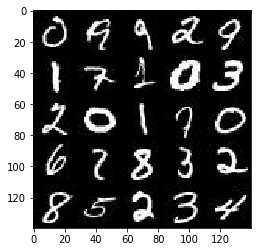

In [9]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

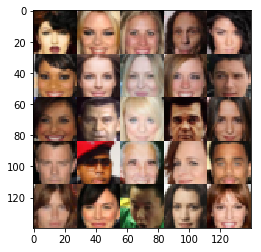

In [10]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [12]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    # The constant used in the leaky ReLU activation function.
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # The discriminator uses the DCGAN architecture. Batch normalization is
        # used on all layers except the first convolutional layer and the output layer.
        # Shape of images: 28x28x3 (CelebA) or 28x28x1 (MNIST)
        
        # First convolutional layer.
        # Resulting shape: 14x14x64
        x1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=(5,5), strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)  # Leaky ReLU
        
        # Second convolutional layer.
        # Resulting shape: 7x7x128
        x2 = tf.layers.conv2d(x1, 128, (5,5), 2, 'same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # Third convolutional layer.
        # Note: According to the TensorFlow documentation, a ceiling operator
        # is applied to the output width and height when using SAME padding.
        # That's why the width and height of 7 are downscaled to 4.
        # See https://www.tensorflow.org/api_guides/python/nn#Convolution.
        # Resulting shape: 4x4x256
        x3 = tf.layers.conv2d(x2, 256, (5,5), 2, 'same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(inputs=flat, units=1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # The constant used in the leaky ReLU activation function.
    alpha = 0.2
    
    # Only reuse variables if we're not training the network.
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # Fully connected layer.
        # Resulting shape: 7x7x512
        x1 = tf.layers.dense(inputs=z, units=7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)  # Leaky ReLU
        
        # First convolutional layer.
        # Resulting shape: 14x14x256
        x2 = tf.layers.conv2d_transpose(inputs=x1, filters=256, kernel_size=(5, 5), strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
                
        # Second convolutional layer.
        # Resulting shape: 28x28x128
        x3 = tf.layers.conv2d_transpose(x2, 128, (5, 5), 2, 'same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Third convolutional layer / output layer.
        # Resulting shape: 28x28x3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, (5, 5), 1, 'same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    # Wether or not to use label smoothing.
    use_label_smoothing = True
    
    # The label smoothing factor used to help the discriminator generalize better.
    smooth = 0.1

    # The generator output.
    g_model = generator(input_z, out_channel_dim, is_train=True)

    # The discriminator output and logits when fed the real and fake images.
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate the discriminator loss.
    # ---------------------------------
    # For real images, the labels are all ones (because they are the real images).
    if use_label_smoothing:
        d_labels_real = tf.ones_like(d_model_real) * (1 - smooth)
    else:
        d_labels_real = tf.ones_like(d_model_real)
    d_cross_entropy_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_real)
    d_loss_real = tf.reduce_mean(d_cross_entropy_real)
    
    # For fake images, the labels are all zeros (because they are the fake images).
    d_lables_fake = tf.zeros_like(d_model_fake) * (1 - smooth)
    d_cross_entroy_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_lables_fake)
    d_loss_fake = tf.reduce_mean(d_cross_entroy_fake)
    
    # Calculate the total loss.
    d_loss = d_loss_real + d_loss_fake
    
    # Calculate the generator loss.
    # -----------------------------
    # Remember, the generator is trying to fool the discriminator into outputting
    # ones for fake images. That's why the labels are set to all ones for the fake output.
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and biases to update, separately for the discriminator and the generator.
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Run the optimizer on the respective discriminator and generator variables.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    print("data_shape={}".format(data_shape))
    print("data_image_mode={}".format(data_image_mode))
    
    # saver = tf.train.Saver()
    
    # Build the model.
    # ----------------
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    # Train the model.
    # ----------------
    batch_i = 0
    losses = []
    n_images = 25
    show_losses_every = 10
    show_output_every = 50
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_i += 1
                
                # Rescale images from (-0.5, 0.5) to (-1, 1), because we're using the
                # tanh activation function in the generator which has a range of (-1, 1).
                batch_images = batch_images * 2

                # Sample random noise for the generator.
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run the optimizers on both the discriminator and the generator.
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                # Note_ We need to pass the values for the placeholders 'input_real'
                # and 'lr' here to satisfy TensorFlow. They aren't actually used.
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                # Print losses every 25 batches.
                if batch_i % show_losses_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Batch {}...".format(batch_i),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    # Save losses to view after training.
                    losses.append((train_loss_d, train_loss_g))

                # Print generator output every 100 batches.
                if batch_i % show_output_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                    
            print("Batches per epoch: {}".format(batch_i))    
            
        show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
        # saver.save(sess, './checkpoints/generator.ckpt')
    
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

data_shape=(60000, 28, 28, 1)
data_image_mode=L
Epoch 1/2... Batch 10... Discriminator Loss: 0.7180... Generator Loss: 4.7730
Epoch 1/2... Batch 20... Discriminator Loss: 0.4243... Generator Loss: 3.7360
Epoch 1/2... Batch 30... Discriminator Loss: 1.0863... Generator Loss: 7.9468
Epoch 1/2... Batch 40... Discriminator Loss: 0.5714... Generator Loss: 3.0127
Epoch 1/2... Batch 50... Discriminator Loss: 0.5032... Generator Loss: 14.5526


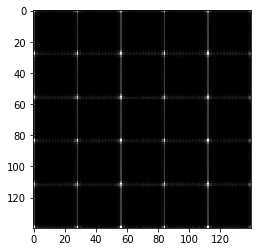

Epoch 1/2... Batch 60... Discriminator Loss: 0.7226... Generator Loss: 2.5050
Epoch 1/2... Batch 70... Discriminator Loss: 1.0508... Generator Loss: 1.8464
Epoch 1/2... Batch 80... Discriminator Loss: 1.5899... Generator Loss: 0.4686
Epoch 1/2... Batch 90... Discriminator Loss: 1.5005... Generator Loss: 2.4711
Epoch 1/2... Batch 100... Discriminator Loss: 1.2468... Generator Loss: 2.2381


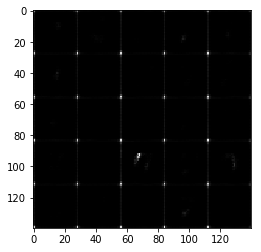

Epoch 1/2... Batch 110... Discriminator Loss: 1.2704... Generator Loss: 1.0009
Epoch 1/2... Batch 120... Discriminator Loss: 2.9787... Generator Loss: 4.4726
Epoch 1/2... Batch 130... Discriminator Loss: 1.0267... Generator Loss: 1.9119
Epoch 1/2... Batch 140... Discriminator Loss: 0.9714... Generator Loss: 1.0680
Epoch 1/2... Batch 150... Discriminator Loss: 1.0057... Generator Loss: 1.0841


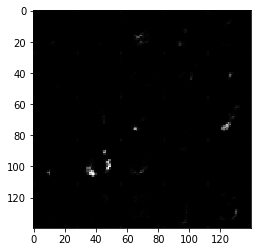

Epoch 1/2... Batch 160... Discriminator Loss: 2.1232... Generator Loss: 4.0030
Epoch 1/2... Batch 170... Discriminator Loss: 1.0936... Generator Loss: 1.0964
Epoch 1/2... Batch 180... Discriminator Loss: 1.4142... Generator Loss: 2.6676
Epoch 1/2... Batch 190... Discriminator Loss: 1.0999... Generator Loss: 1.1416
Epoch 1/2... Batch 200... Discriminator Loss: 1.3780... Generator Loss: 0.5873


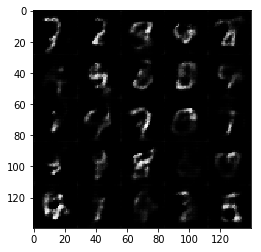

Epoch 1/2... Batch 210... Discriminator Loss: 1.1196... Generator Loss: 1.1122
Epoch 1/2... Batch 220... Discriminator Loss: 1.2116... Generator Loss: 1.5840
Epoch 1/2... Batch 230... Discriminator Loss: 1.1496... Generator Loss: 0.8742
Batches per epoch: 234
Epoch 2/2... Batch 240... Discriminator Loss: 1.3757... Generator Loss: 2.0770
Epoch 2/2... Batch 250... Discriminator Loss: 1.0896... Generator Loss: 0.9705


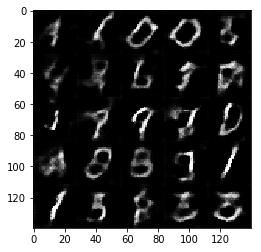

Epoch 2/2... Batch 260... Discriminator Loss: 1.2015... Generator Loss: 1.1605
Epoch 2/2... Batch 270... Discriminator Loss: 1.1942... Generator Loss: 0.8464
Epoch 2/2... Batch 280... Discriminator Loss: 1.3287... Generator Loss: 1.7713
Epoch 2/2... Batch 290... Discriminator Loss: 1.3699... Generator Loss: 1.5828
Epoch 2/2... Batch 300... Discriminator Loss: 1.0738... Generator Loss: 1.1974


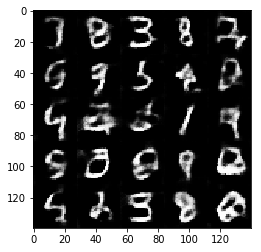

Epoch 2/2... Batch 310... Discriminator Loss: 1.2881... Generator Loss: 0.6553
Epoch 2/2... Batch 320... Discriminator Loss: 1.1294... Generator Loss: 1.3605
Epoch 2/2... Batch 330... Discriminator Loss: 1.5821... Generator Loss: 0.4384
Epoch 2/2... Batch 340... Discriminator Loss: 1.1300... Generator Loss: 1.0153
Epoch 2/2... Batch 350... Discriminator Loss: 1.1277... Generator Loss: 1.2875


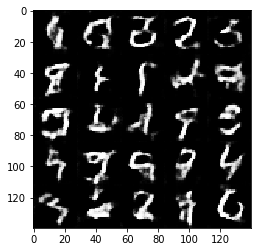

Epoch 2/2... Batch 360... Discriminator Loss: 1.1389... Generator Loss: 1.0394
Epoch 2/2... Batch 370... Discriminator Loss: 1.1881... Generator Loss: 0.8034
Epoch 2/2... Batch 380... Discriminator Loss: 1.2041... Generator Loss: 0.7492
Epoch 2/2... Batch 390... Discriminator Loss: 1.1993... Generator Loss: 0.6814
Epoch 2/2... Batch 400... Discriminator Loss: 1.0711... Generator Loss: 1.0566


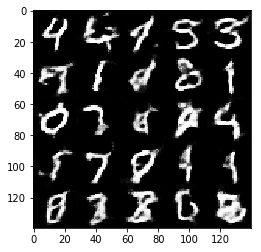

Epoch 2/2... Batch 410... Discriminator Loss: 1.1694... Generator Loss: 0.7558
Epoch 2/2... Batch 420... Discriminator Loss: 1.5172... Generator Loss: 2.2617
Epoch 2/2... Batch 430... Discriminator Loss: 1.0596... Generator Loss: 1.3156
Epoch 2/2... Batch 440... Discriminator Loss: 1.2269... Generator Loss: 1.7203
Epoch 2/2... Batch 450... Discriminator Loss: 1.2037... Generator Loss: 1.9031


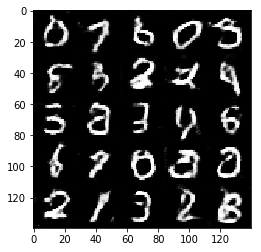

Epoch 2/2... Batch 460... Discriminator Loss: 1.1208... Generator Loss: 1.0461
Batches per epoch: 468


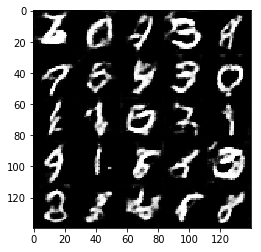

In [23]:
batch_size = 256
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses_mnist = train(epochs, batch_size, z_dim, learning_rate, beta1, 
                         mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)

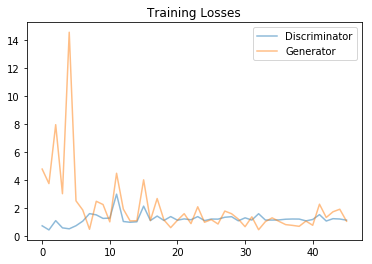

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt

losses_mnist = np.array(losses_mnist)
plt.plot(losses_mnist.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses_mnist.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data_shape=(202599, 28, 28, 3)
data_image_mode=RGB
Epoch 1/1... Batch 10... Discriminator Loss: 0.3915... Generator Loss: 5.4256
Epoch 1/1... Batch 20... Discriminator Loss: 0.4315... Generator Loss: 4.4235
Epoch 1/1... Batch 30... Discriminator Loss: 0.4856... Generator Loss: 2.6285
Epoch 1/1... Batch 40... Discriminator Loss: 0.5854... Generator Loss: 3.7478
Epoch 1/1... Batch 50... Discriminator Loss: 2.2372... Generator Loss: 11.0706


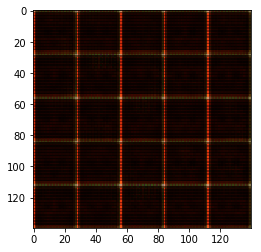

Epoch 1/1... Batch 60... Discriminator Loss: 1.3597... Generator Loss: 0.6317
Epoch 1/1... Batch 70... Discriminator Loss: 0.8819... Generator Loss: 1.1618
Epoch 1/1... Batch 80... Discriminator Loss: 0.6560... Generator Loss: 1.8077
Epoch 1/1... Batch 90... Discriminator Loss: 0.5583... Generator Loss: 3.4664
Epoch 1/1... Batch 100... Discriminator Loss: 0.8279... Generator Loss: 3.3154


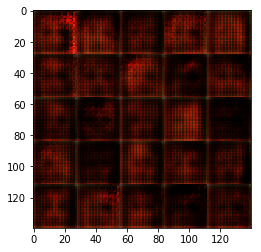

Epoch 1/1... Batch 110... Discriminator Loss: 1.4339... Generator Loss: 2.3281
Epoch 1/1... Batch 120... Discriminator Loss: 1.7692... Generator Loss: 3.4557
Epoch 1/1... Batch 130... Discriminator Loss: 0.8373... Generator Loss: 1.9459
Epoch 1/1... Batch 140... Discriminator Loss: 1.1237... Generator Loss: 0.8952
Epoch 1/1... Batch 150... Discriminator Loss: 1.0569... Generator Loss: 1.4986


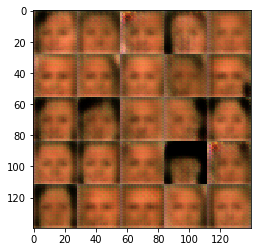

Epoch 1/1... Batch 160... Discriminator Loss: 1.9136... Generator Loss: 2.3474
Epoch 1/1... Batch 170... Discriminator Loss: 0.6893... Generator Loss: 2.2319
Epoch 1/1... Batch 180... Discriminator Loss: 1.6176... Generator Loss: 0.4599
Epoch 1/1... Batch 190... Discriminator Loss: 1.1146... Generator Loss: 0.9037
Epoch 1/1... Batch 200... Discriminator Loss: 0.8999... Generator Loss: 1.4171


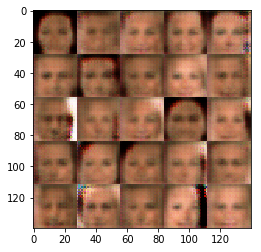

Epoch 1/1... Batch 210... Discriminator Loss: 1.1460... Generator Loss: 1.3082
Epoch 1/1... Batch 220... Discriminator Loss: 1.1112... Generator Loss: 0.8727
Epoch 1/1... Batch 230... Discriminator Loss: 1.1854... Generator Loss: 1.5720
Epoch 1/1... Batch 240... Discriminator Loss: 1.2389... Generator Loss: 0.8938
Epoch 1/1... Batch 250... Discriminator Loss: 1.9764... Generator Loss: 3.2880


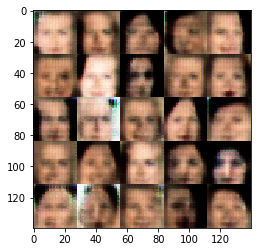

Epoch 1/1... Batch 260... Discriminator Loss: 1.2651... Generator Loss: 1.6905
Epoch 1/1... Batch 270... Discriminator Loss: 1.0823... Generator Loss: 1.7489
Epoch 1/1... Batch 280... Discriminator Loss: 1.1430... Generator Loss: 1.0776
Epoch 1/1... Batch 290... Discriminator Loss: 1.4329... Generator Loss: 0.5034
Epoch 1/1... Batch 300... Discriminator Loss: 1.0984... Generator Loss: 1.2843


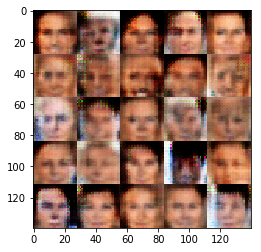

Epoch 1/1... Batch 310... Discriminator Loss: 1.6489... Generator Loss: 1.7370
Epoch 1/1... Batch 320... Discriminator Loss: 1.2105... Generator Loss: 1.5893
Epoch 1/1... Batch 330... Discriminator Loss: 1.4734... Generator Loss: 1.7812
Epoch 1/1... Batch 340... Discriminator Loss: 1.4050... Generator Loss: 1.3918
Epoch 1/1... Batch 350... Discriminator Loss: 1.2940... Generator Loss: 0.9572


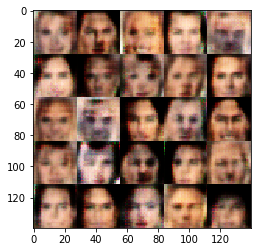

Epoch 1/1... Batch 360... Discriminator Loss: 1.0829... Generator Loss: 0.8089
Epoch 1/1... Batch 370... Discriminator Loss: 0.9854... Generator Loss: 2.0128
Epoch 1/1... Batch 380... Discriminator Loss: 1.2767... Generator Loss: 1.2479
Epoch 1/1... Batch 390... Discriminator Loss: 1.2501... Generator Loss: 2.2636
Epoch 1/1... Batch 400... Discriminator Loss: 1.2549... Generator Loss: 1.1805


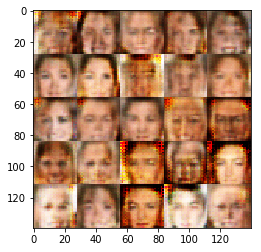

Epoch 1/1... Batch 410... Discriminator Loss: 1.5288... Generator Loss: 0.3996
Epoch 1/1... Batch 420... Discriminator Loss: 0.9761... Generator Loss: 1.6164
Epoch 1/1... Batch 430... Discriminator Loss: 3.1081... Generator Loss: 3.5633
Epoch 1/1... Batch 440... Discriminator Loss: 1.0404... Generator Loss: 1.4961
Epoch 1/1... Batch 450... Discriminator Loss: 1.0860... Generator Loss: 1.1059


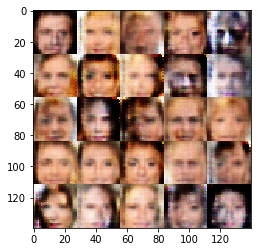

Epoch 1/1... Batch 460... Discriminator Loss: 1.3549... Generator Loss: 0.7839
Epoch 1/1... Batch 470... Discriminator Loss: 0.9930... Generator Loss: 1.1480
Epoch 1/1... Batch 480... Discriminator Loss: 1.3169... Generator Loss: 0.7792
Epoch 1/1... Batch 490... Discriminator Loss: 1.0935... Generator Loss: 1.2329
Epoch 1/1... Batch 500... Discriminator Loss: 1.4063... Generator Loss: 0.4918


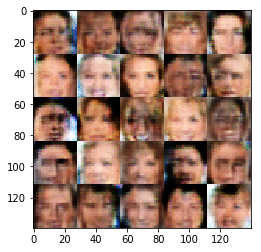

Epoch 1/1... Batch 510... Discriminator Loss: 1.8758... Generator Loss: 2.2603
Epoch 1/1... Batch 520... Discriminator Loss: 1.2426... Generator Loss: 0.6480
Epoch 1/1... Batch 530... Discriminator Loss: 1.0570... Generator Loss: 0.8344
Epoch 1/1... Batch 540... Discriminator Loss: 1.0424... Generator Loss: 1.0732
Epoch 1/1... Batch 550... Discriminator Loss: 1.4421... Generator Loss: 0.6734


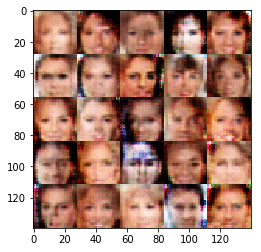

Epoch 1/1... Batch 560... Discriminator Loss: 1.2933... Generator Loss: 0.6368
Epoch 1/1... Batch 570... Discriminator Loss: 1.0866... Generator Loss: 1.8158
Epoch 1/1... Batch 580... Discriminator Loss: 1.0112... Generator Loss: 1.0795
Epoch 1/1... Batch 590... Discriminator Loss: 1.0940... Generator Loss: 1.2918
Epoch 1/1... Batch 600... Discriminator Loss: 1.2643... Generator Loss: 1.7382


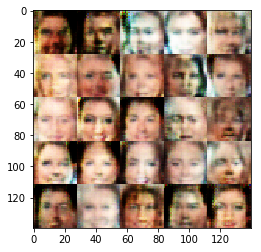

Epoch 1/1... Batch 610... Discriminator Loss: 1.2359... Generator Loss: 0.9367
Epoch 1/1... Batch 620... Discriminator Loss: 1.1000... Generator Loss: 0.9748
Epoch 1/1... Batch 630... Discriminator Loss: 0.9895... Generator Loss: 1.0148
Epoch 1/1... Batch 640... Discriminator Loss: 2.0756... Generator Loss: 3.1608
Epoch 1/1... Batch 650... Discriminator Loss: 1.4933... Generator Loss: 0.8562


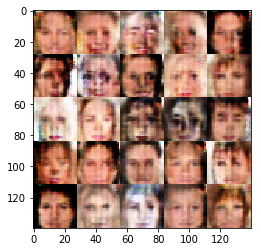

Epoch 1/1... Batch 660... Discriminator Loss: 0.8445... Generator Loss: 1.3911
Epoch 1/1... Batch 670... Discriminator Loss: 1.2222... Generator Loss: 1.1342
Epoch 1/1... Batch 680... Discriminator Loss: 1.3524... Generator Loss: 1.8361
Epoch 1/1... Batch 690... Discriminator Loss: 0.9602... Generator Loss: 1.2819
Epoch 1/1... Batch 700... Discriminator Loss: 1.1388... Generator Loss: 2.0244


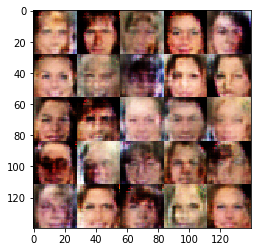

Epoch 1/1... Batch 710... Discriminator Loss: 1.2037... Generator Loss: 0.7353
Epoch 1/1... Batch 720... Discriminator Loss: 1.3421... Generator Loss: 0.6506
Epoch 1/1... Batch 730... Discriminator Loss: 1.2251... Generator Loss: 0.8996
Epoch 1/1... Batch 740... Discriminator Loss: 1.3627... Generator Loss: 1.6347
Epoch 1/1... Batch 750... Discriminator Loss: 0.9977... Generator Loss: 1.3709


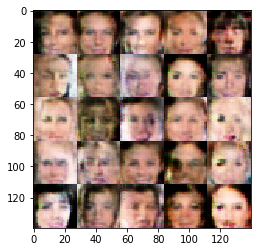

Epoch 1/1... Batch 760... Discriminator Loss: 1.1305... Generator Loss: 1.5037
Epoch 1/1... Batch 770... Discriminator Loss: 1.2017... Generator Loss: 0.6865
Epoch 1/1... Batch 780... Discriminator Loss: 1.2095... Generator Loss: 0.7361
Epoch 1/1... Batch 790... Discriminator Loss: 1.1459... Generator Loss: 0.7226
Epoch 1/1... Batch 800... Discriminator Loss: 1.3515... Generator Loss: 1.7974


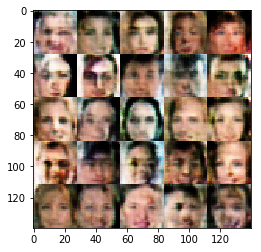

Epoch 1/1... Batch 810... Discriminator Loss: 1.1637... Generator Loss: 0.8803
Epoch 1/1... Batch 820... Discriminator Loss: 1.3345... Generator Loss: 0.5767
Epoch 1/1... Batch 830... Discriminator Loss: 1.3484... Generator Loss: 2.0463
Epoch 1/1... Batch 840... Discriminator Loss: 1.1840... Generator Loss: 0.6363
Epoch 1/1... Batch 850... Discriminator Loss: 1.7141... Generator Loss: 1.3221


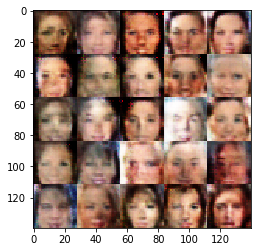

Epoch 1/1... Batch 860... Discriminator Loss: 0.8393... Generator Loss: 1.6122
Epoch 1/1... Batch 870... Discriminator Loss: 1.5320... Generator Loss: 0.4713
Epoch 1/1... Batch 880... Discriminator Loss: 0.7148... Generator Loss: 2.0858
Epoch 1/1... Batch 890... Discriminator Loss: 2.2945... Generator Loss: 0.1843
Epoch 1/1... Batch 900... Discriminator Loss: 1.1081... Generator Loss: 0.8376


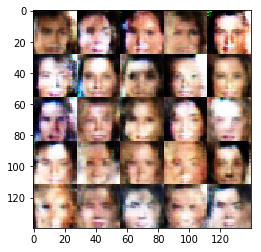

Epoch 1/1... Batch 910... Discriminator Loss: 0.8269... Generator Loss: 1.5882
Epoch 1/1... Batch 920... Discriminator Loss: 0.9323... Generator Loss: 1.0587
Epoch 1/1... Batch 930... Discriminator Loss: 1.2161... Generator Loss: 1.2296
Epoch 1/1... Batch 940... Discriminator Loss: 1.0011... Generator Loss: 1.2334
Epoch 1/1... Batch 950... Discriminator Loss: 0.6234... Generator Loss: 1.9077


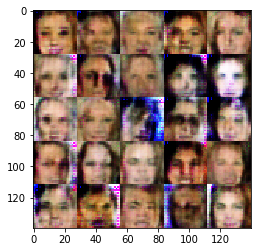

Epoch 1/1... Batch 960... Discriminator Loss: 0.9357... Generator Loss: 1.0787
Epoch 1/1... Batch 970... Discriminator Loss: 1.1394... Generator Loss: 0.8511
Epoch 1/1... Batch 980... Discriminator Loss: 1.1429... Generator Loss: 0.8603
Epoch 1/1... Batch 990... Discriminator Loss: 1.4051... Generator Loss: 0.5155
Epoch 1/1... Batch 1000... Discriminator Loss: 0.9899... Generator Loss: 0.9581


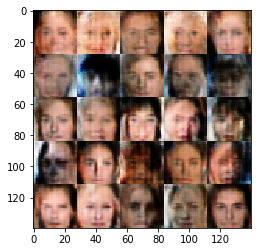

Epoch 1/1... Batch 1010... Discriminator Loss: 1.6788... Generator Loss: 2.6838
Epoch 1/1... Batch 1020... Discriminator Loss: 0.9692... Generator Loss: 1.8410
Epoch 1/1... Batch 1030... Discriminator Loss: 1.1001... Generator Loss: 0.8832
Epoch 1/1... Batch 1040... Discriminator Loss: 1.0897... Generator Loss: 0.9679
Epoch 1/1... Batch 1050... Discriminator Loss: 1.2990... Generator Loss: 0.6050


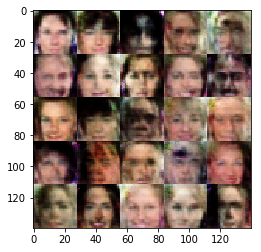

Epoch 1/1... Batch 1060... Discriminator Loss: 1.2278... Generator Loss: 0.7963
Epoch 1/1... Batch 1070... Discriminator Loss: 1.2409... Generator Loss: 0.9037
Epoch 1/1... Batch 1080... Discriminator Loss: 1.4953... Generator Loss: 0.4908
Epoch 1/1... Batch 1090... Discriminator Loss: 1.8570... Generator Loss: 0.2883
Epoch 1/1... Batch 1100... Discriminator Loss: 0.8157... Generator Loss: 1.9755


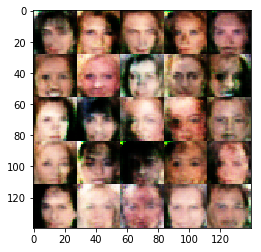

Epoch 1/1... Batch 1110... Discriminator Loss: 1.3750... Generator Loss: 0.7170
Epoch 1/1... Batch 1120... Discriminator Loss: 1.0499... Generator Loss: 1.2500
Epoch 1/1... Batch 1130... Discriminator Loss: 0.9963... Generator Loss: 0.9688
Epoch 1/1... Batch 1140... Discriminator Loss: 1.4664... Generator Loss: 1.7670
Epoch 1/1... Batch 1150... Discriminator Loss: 0.9792... Generator Loss: 1.7278


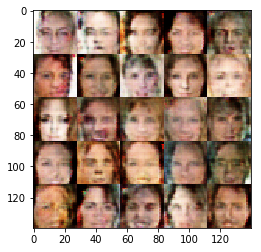

Epoch 1/1... Batch 1160... Discriminator Loss: 1.2644... Generator Loss: 0.7941
Epoch 1/1... Batch 1170... Discriminator Loss: 1.1440... Generator Loss: 0.9614
Epoch 1/1... Batch 1180... Discriminator Loss: 0.9849... Generator Loss: 1.4451
Epoch 1/1... Batch 1190... Discriminator Loss: 1.1262... Generator Loss: 0.9361
Epoch 1/1... Batch 1200... Discriminator Loss: 1.2683... Generator Loss: 0.6621


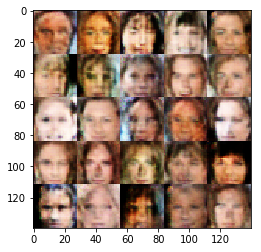

Epoch 1/1... Batch 1210... Discriminator Loss: 1.1456... Generator Loss: 0.8838
Epoch 1/1... Batch 1220... Discriminator Loss: 1.3528... Generator Loss: 0.7653
Epoch 1/1... Batch 1230... Discriminator Loss: 1.3595... Generator Loss: 0.5810
Epoch 1/1... Batch 1240... Discriminator Loss: 1.2143... Generator Loss: 1.2375
Epoch 1/1... Batch 1250... Discriminator Loss: 1.2026... Generator Loss: 1.2863


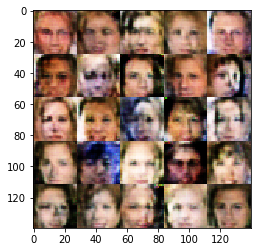

Epoch 1/1... Batch 1260... Discriminator Loss: 1.3334... Generator Loss: 0.6432
Epoch 1/1... Batch 1270... Discriminator Loss: 1.4573... Generator Loss: 0.7088
Epoch 1/1... Batch 1280... Discriminator Loss: 1.1775... Generator Loss: 0.9395
Epoch 1/1... Batch 1290... Discriminator Loss: 1.2505... Generator Loss: 0.6626
Epoch 1/1... Batch 1300... Discriminator Loss: 1.4136... Generator Loss: 0.5056


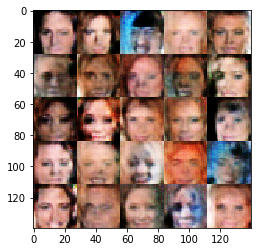

Epoch 1/1... Batch 1310... Discriminator Loss: 1.4952... Generator Loss: 0.4381
Epoch 1/1... Batch 1320... Discriminator Loss: 1.3447... Generator Loss: 0.7137
Epoch 1/1... Batch 1330... Discriminator Loss: 1.1497... Generator Loss: 0.8575
Epoch 1/1... Batch 1340... Discriminator Loss: 1.0381... Generator Loss: 1.0355
Epoch 1/1... Batch 1350... Discriminator Loss: 1.3667... Generator Loss: 0.6044


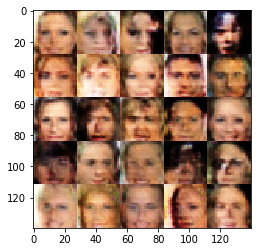

Epoch 1/1... Batch 1360... Discriminator Loss: 1.2624... Generator Loss: 0.6537
Epoch 1/1... Batch 1370... Discriminator Loss: 1.3383... Generator Loss: 0.8171
Epoch 1/1... Batch 1380... Discriminator Loss: 1.4919... Generator Loss: 1.6452
Epoch 1/1... Batch 1390... Discriminator Loss: 1.3547... Generator Loss: 0.5431
Epoch 1/1... Batch 1400... Discriminator Loss: 1.1287... Generator Loss: 0.9683


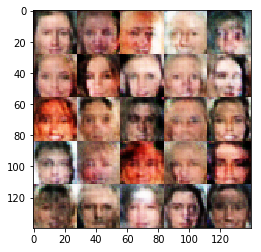

Epoch 1/1... Batch 1410... Discriminator Loss: 1.2555... Generator Loss: 0.7207
Epoch 1/1... Batch 1420... Discriminator Loss: 0.9999... Generator Loss: 0.9915
Epoch 1/1... Batch 1430... Discriminator Loss: 1.7731... Generator Loss: 2.1214
Epoch 1/1... Batch 1440... Discriminator Loss: 1.1095... Generator Loss: 1.0974
Epoch 1/1... Batch 1450... Discriminator Loss: 0.9702... Generator Loss: 1.1514


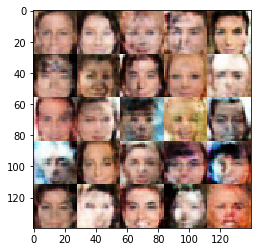

Epoch 1/1... Batch 1460... Discriminator Loss: 1.3054... Generator Loss: 1.4526
Epoch 1/1... Batch 1470... Discriminator Loss: 1.8561... Generator Loss: 2.4172
Epoch 1/1... Batch 1480... Discriminator Loss: 1.1845... Generator Loss: 1.8181
Epoch 1/1... Batch 1490... Discriminator Loss: 1.4442... Generator Loss: 1.3398
Epoch 1/1... Batch 1500... Discriminator Loss: 0.9617... Generator Loss: 1.3710


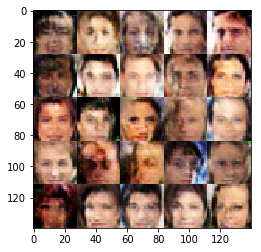

Epoch 1/1... Batch 1510... Discriminator Loss: 1.2261... Generator Loss: 0.6181
Epoch 1/1... Batch 1520... Discriminator Loss: 1.2703... Generator Loss: 1.5673
Epoch 1/1... Batch 1530... Discriminator Loss: 1.1006... Generator Loss: 0.8611
Epoch 1/1... Batch 1540... Discriminator Loss: 1.3439... Generator Loss: 1.0846
Epoch 1/1... Batch 1550... Discriminator Loss: 1.0027... Generator Loss: 1.0638


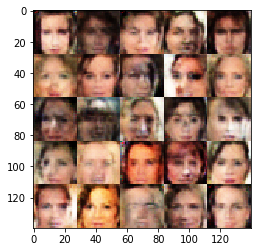

Epoch 1/1... Batch 1560... Discriminator Loss: 0.9702... Generator Loss: 1.1931
Epoch 1/1... Batch 1570... Discriminator Loss: 1.0206... Generator Loss: 0.9457
Epoch 1/1... Batch 1580... Discriminator Loss: 1.2791... Generator Loss: 1.0823
Batches per epoch: 1582


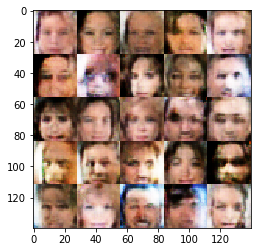

In [21]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses_celeba = train(epochs, batch_size, z_dim, learning_rate, beta1,
                          celeba_dataset.get_batches, celeba_dataset.shape, celeba_dataset.image_mode)

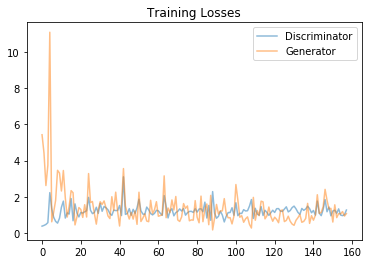

In [22]:
losses_celeba = np.array(losses_celeba)
plt.plot(losses_celeba.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses_celeba.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.